# Tree based models




Nos ponemos en la situación de un analista de datos trabajando por un banco, en la que nos dicen: 'Tú que has estudiado un master de IA te pasaremos un conjunto de datos y queremos que los estudies con árboles para clasificar nuevos datos'. Estos datos provienen de un banco, por lo que para no comprometer la seguridad de sus usuarios las variables no tienen nombres (se llaman A1, A2, A3...) y además las categóricas están camufladas como letras (por ejemplo, en vez de variable sexo y valores hombre o mujer pues igual tenemos variable A12 y valores f y t). Lo único que sabemos es que los datos son provenientes del banco y queremos enfrentarnos a un problema de clasificación en el que clasificamos a los clientes en según si se les ha dado un crédito o no.

Lo primero que haremos será cargar las librerías que necesitaremos

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz, plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn import metrics as skm


## Lectura de datos y tratamiento de NA's



Ahora pasaremos a la lectura de los datos, el dataset que he elegido es [Credit Approval](https://archive.ics.uci.edu/dataset/27/credit+approval)

In [ ]:
nombre_archivo = 'crx.data'


df = pd.read_csv(
    nombre_archivo,
    header=None,
    sep= ','  ,
    na_values=['?']
)


nombres=[]
for i in range(1,16):
    i=str(i)
    nombres=nombres+["A"+i]

nombres=nombres+["clas."]
df.columns=nombres
df[1:10] #imprimimos los 10 primeros para ver algunos datos

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,clas.
1,a,58.67,4.460,u,g,q,h,3.040,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.500,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.750,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.710,t,f,0,f,s,120.0,0,+
5,b,32.08,4.000,u,g,m,v,2.500,t,f,0,t,g,360.0,0,+
6,b,33.17,1.040,u,g,r,h,6.500,t,f,0,t,g,164.0,31285,+
7,a,22.92,11.585,u,g,cc,v,0.040,t,f,0,f,g,80.0,1349,+
8,b,54.42,0.500,y,p,k,h,3.960,t,f,0,f,g,180.0,314,+
9,b,42.50,4.915,y,p,w,v,3.165,t,f,0,t,g,52.0,1442,+


Ahora veremos un resumen de nuestros datos, tanto de los factores como de los continuos y además cuántos datos faltantes hay

In [ ]:
print(df.describe())

print("\n")

columnas_categoricas =list(df.select_dtypes(include=['object', 'category']).columns)
columnas_continuas = list(df.select_dtypes(include=['float64', 'int64']).columns)

for i in columnas_categoricas:
    print(f"--- Resumen para la columna: {i} ---")
    print(df[i].value_counts())
    # print(df[i].value_counts(normalize=True) * 100) Esto si queremos el porcentaje
    print("\n")

print(f"--- Número de datos faltantes por columna ---")
print(df.isnull().sum())

               A2          A3          A8        A11          A14  \
count  678.000000  690.000000  690.000000  690.00000   677.000000   
mean    31.568171    4.758725    2.223406    2.40000   184.014771   
std     11.957862    4.978163    3.346513    4.86294   173.806768   
min     13.750000    0.000000    0.000000    0.00000     0.000000   
25%     22.602500    1.000000    0.165000    0.00000    75.000000   
50%     28.460000    2.750000    1.000000    0.00000   160.000000   
75%     38.230000    7.207500    2.625000    3.00000   276.000000   
max     80.250000   28.000000   28.500000   67.00000  2000.000000   

                 A15  
count     690.000000  
mean     1017.385507  
std      5210.102598  
min         0.000000  
25%         0.000000  
50%         5.000000  
75%       395.500000  
max    100000.000000  


--- Resumen para la columna: A1 ---
A1
b    468
a    210
Name: count, dtype: int64


--- Resumen para la columna: A4 ---
A4
u    519
y    163
l      2
Name: count, dtype

Ahora trataremos los datos faltantes, tenemos dos opciones:
 - Opción número 1: Omitir todos los ejemplos que tengan algún dato faltante
 - Opción número 2: Sustituir los datos faltantes para no tener que eliminar ejemplos, podríamos sustituir los NA de variables categóricas por la moda y los NA de variables continuas por la media.

Veamos cuantos NA hay en total y nos pondremos en el peor caso, que cada NA está en un ejemplo distinto, veamos cuanta propoción de ejemplos perderíamos si los omitieramos. Por ejemplo, perder un 1% de los ejemplos quizas nos da un poco igual, pero perder 50% es perder muchos ejemplos.

In [ ]:
#Calculamos el total de NA'set
print("--- Número de NA's en total ---")
print(df.isnull().sum().sum())
print("\n")

#Calculamos el total de ejemplos
print("--- Número de ejemplos en nuestros datos ---")
print(df.shape[0])
print("\n")

print(f"--- Porcentaje máximo de ejemplos con NA ---")
print(f"{round(df.isnull().sum().sum()/df.shape[0] * 100,2)} %")

--- Número de NA's en total ---
67


--- Número de ejemplos en nuestros datos ---
690


--- Porcentaje máximo de ejemplos con NA ---
9.71 %


Lo que vamos a hacer va a ser sustituir los valores NA por la media o la moda según corresponda.

In [ ]:
for col in columnas_continuas:
    # 1. Calculo de la media SÓLO con los valores no nulos
    media_col = df[col].mean()

    # 2. Se rellenan los NaN de esa columna con la media calculada
    df[col]=df[col].fillna(media_col)

print("Imputación por Media completada para variables continuas.")


#Imputación de la moda
for col in columnas_categoricas:
    # 1. Calculo de la moda. mode() devuelve una Serie, así que tomamos el primer valor [0]
    moda_col = df[col].mode()[0]

    # 2. Se rellenan los NaN de esa columna con la moda calculada
    df[col]=df[col].fillna(moda_col)

print("Imputación por Moda completada para variables categóricas.")

# Debería devolver 0 para todas las columnas
print("\nConteo final de valores faltantes:")
print(df.isnull().sum())

Imputación por Media completada para variables continuas.
Imputación por Moda completada para variables categóricas.

Conteo final de valores faltantes:
A1       0
A2       0
A3       0
A4       0
A5       0
A6       0
A7       0
A8       0
A9       0
A10      0
A11      0
A12      0
A13      0
A14      0
A15      0
clas.    0
dtype: int64


Sabiendo que ya hay 0 NA, ahora pasaremos convertiremos las variables categóricas a tipo 'category' y además las convertiremos a números para poder trabajar con ellas.

In [ ]:
for i in columnas_categoricas:
    df[i] = df[i].astype('category')
    df[i]= df[i].cat.codes


df[:10]
for i in columnas_categoricas:
    print(df[i].value_counts())

#Vemos que se nos ha puesto la clasificación positiva como 0 y la negativa como 1,
# y lo queremos al reves, así que lo arreglamos.
df['clas.']= 1- df['clas.']
print(df['clas.'].value_counts())


A1
1    480
0    210
Name: count, dtype: int64
A4
1    525
2    163
0      2
Name: count, dtype: int64
A5
0    525
2    163
1      2
Name: count, dtype: int64
A6
1     146
10     78
12     64
6      59
0      54
5      53
8      51
2      41
13     38
9      38
3      30
4      25
7      10
11      3
Name: count, dtype: int64
A7
7    408
3    138
0     59
2     57
4      8
8      8
1      6
5      4
6      2
Name: count, dtype: int64
A9
1    361
0    329
Name: count, dtype: int64
A10
0    395
1    295
Name: count, dtype: int64
A12
0    374
1    316
Name: count, dtype: int64
A13
0    625
2     57
1      8
Name: count, dtype: int64
clas.
1    383
0    307
Name: count, dtype: int64
clas.
0    383
1    307
Name: count, dtype: int64


In [ ]:
df[:10]

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,clas.
0,1,30.83,0.000,1,0,12,7,1.250,1,1,1,0,0,202.0,0,1
1,0,58.67,4.460,1,0,10,3,3.040,1,1,6,0,0,43.0,560,1
2,0,24.50,0.500,1,0,10,3,1.500,1,0,0,0,0,280.0,824,1
3,1,27.83,1.540,1,0,12,7,3.750,1,1,5,1,0,100.0,3,1
4,1,20.17,5.625,1,0,12,7,1.710,1,0,0,0,2,120.0,0,1
5,1,32.08,4.000,1,0,9,7,2.500,1,0,0,1,0,360.0,0,1
6,1,33.17,1.040,1,0,11,3,6.500,1,0,0,1,0,164.0,31285,1
7,0,22.92,11.585,1,0,2,7,0.040,1,0,0,0,0,80.0,1349,1
8,1,54.42,0.500,2,2,8,3,3.960,1,0,0,0,0,180.0,314,1
9,1,42.50,4.915,2,2,12,7,3.165,1,0,0,1,0,52.0,1442,1


Vemos que ya están todas las variables categóricas con formato numérico también.

## Visualización de los datos


### *Scatter Matrix*


Con todo esto preparado, pasamos a la visualización de nuestros datos. Haremos la *scatter_matrix*, que es la representación 2 a 2 de las variables continuas y las coloreamos según su clasificación, donde el color morado quiere decir clasificado como 0 (-) y el color amarillo es el clasificado como 1 (+)

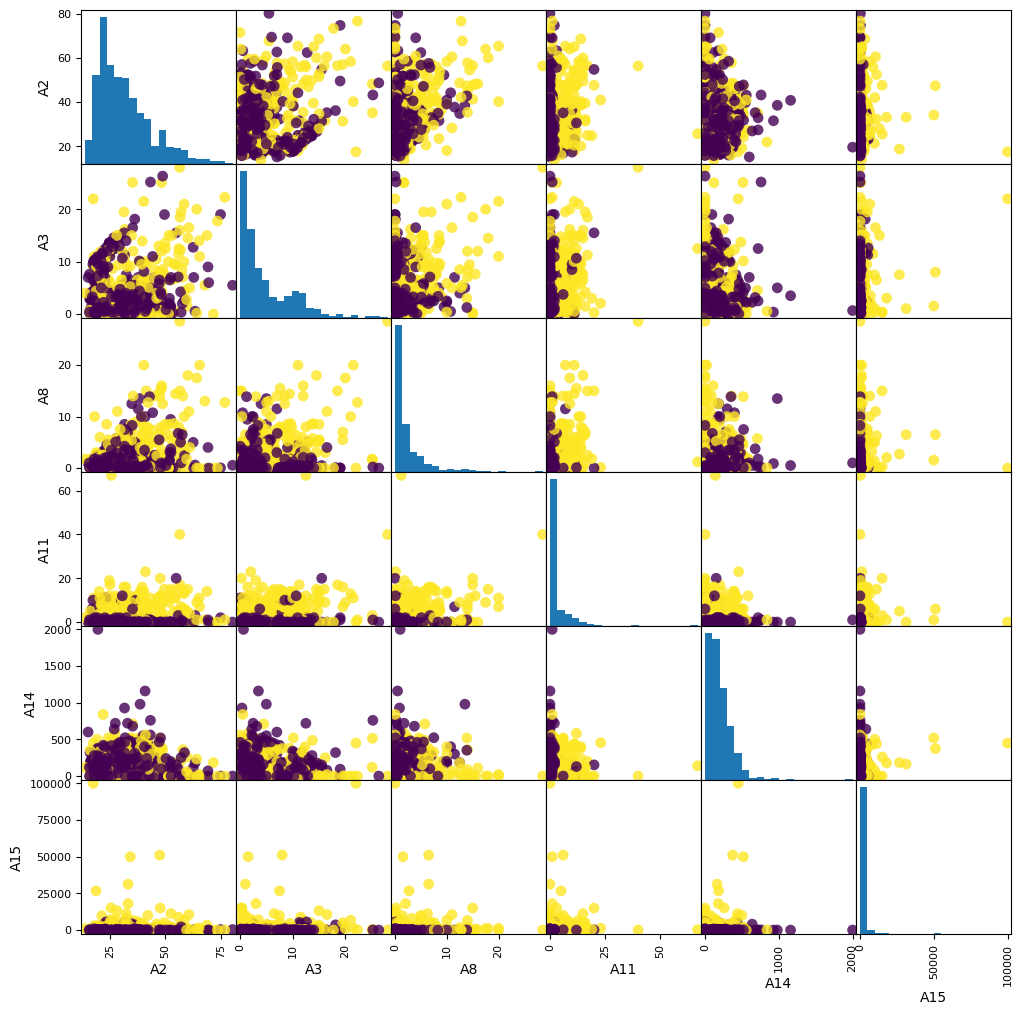

In [ ]:
sp = pd.plotting.scatter_matrix(df[columnas_continuas], c=df['clas.'], figsize=(12, 12), marker='o',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8)

Vemos que por lo general, están bastante mezclados

### Variables continuas: *Boxplots*

Ahora pasamos a ver cada variable individualmente, separandolas por su valor de clasificación. Para las continuas haremos graficos de tipo *boxplot*

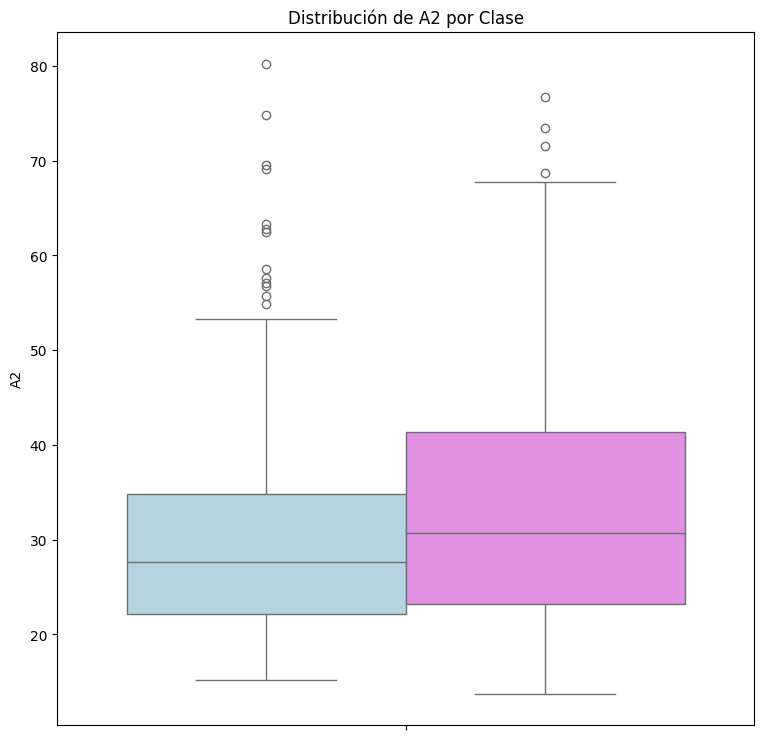

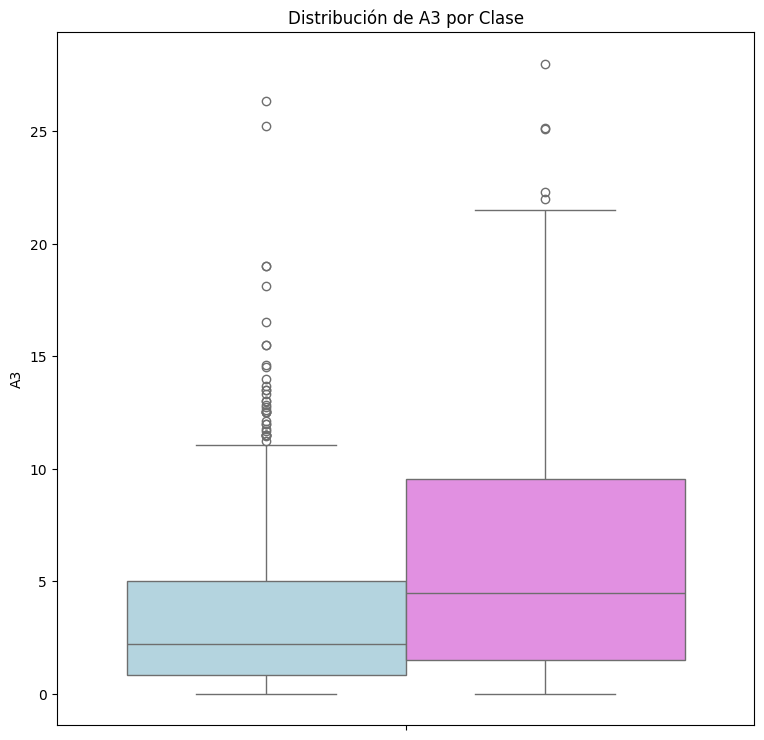

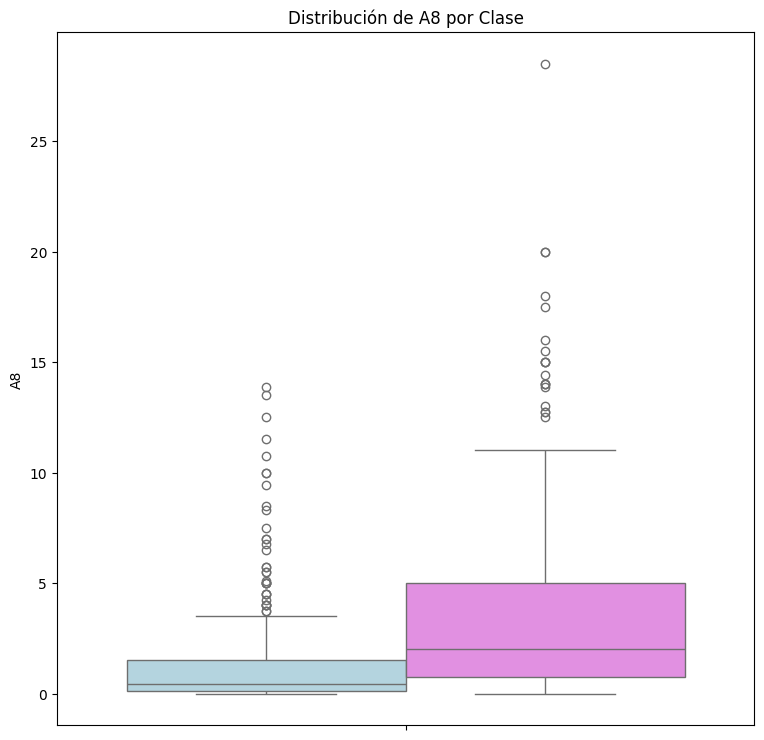

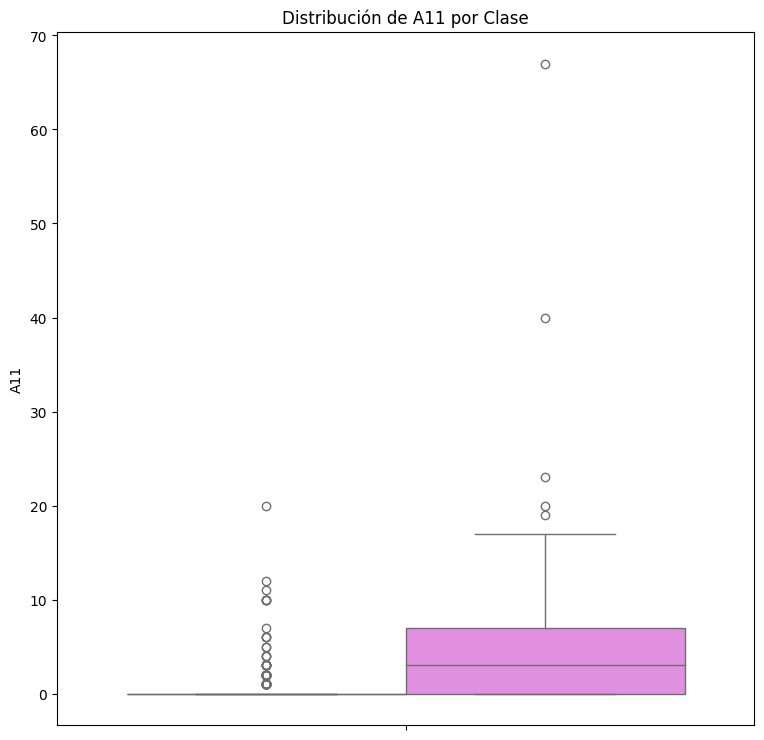

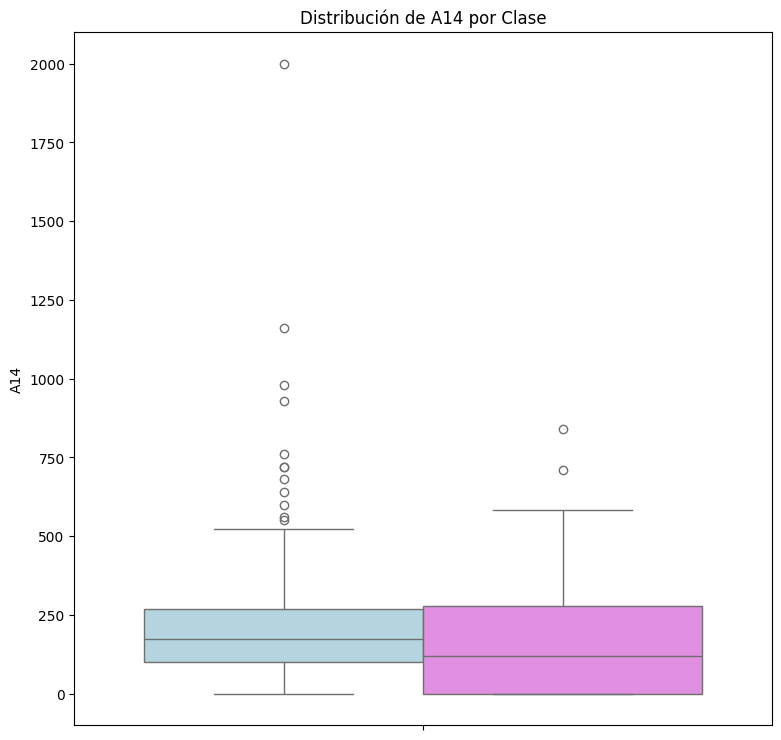

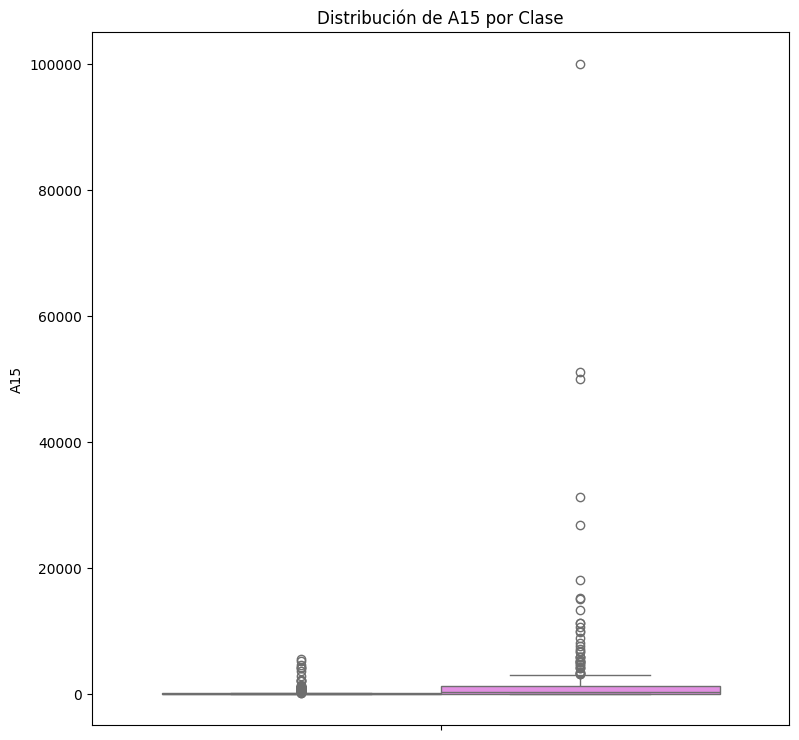

In [ ]:
for i in columnas_continuas:
    sns.boxplot(hue=df['clas.'], y=df[i],legend=False,palette=['lightblue','violet'])
    plt.title(f'Distribución de {i} por Clase')
    plt.show()

Esta ha sido la representación individual, en la que vemos que hay bastantes *ouliers*, cosa que es lógica al tener un buen número de ejemplos. Ahora los representamos todos juntos para poder compararlos entre sí y ver cuales quizás nos ayudan más para nuestra tarea de clasificación.

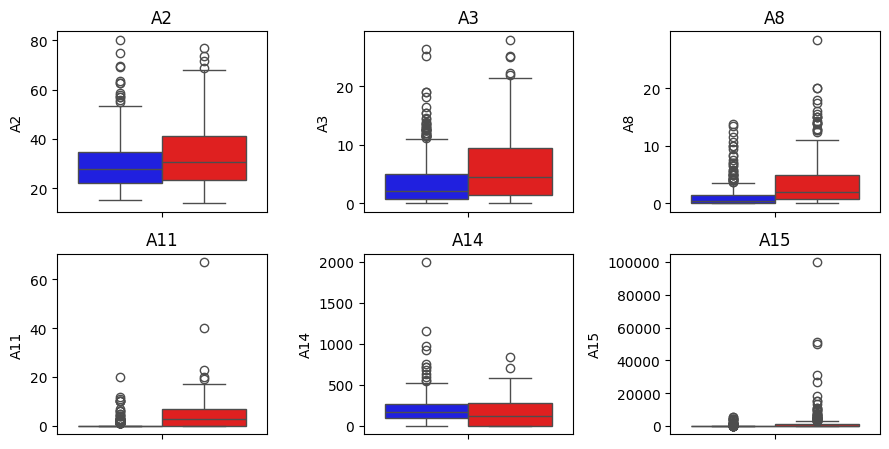

In [ ]:
colores = ['blue','red']

plt.rcParams["figure.figsize"] = [9,9]

for i,n in enumerate(columnas_continuas):
    plt.subplot(4,3,i+1)
    sns.boxplot(y=df[n], hue=df['clas.'].astype('category').cat.codes,
                palette=colores, legend=False)
    plt.title(n)

plt.tight_layout()
plt.show()

Vemos que las variables A8, A3, A11 y A14, varían mucho según sus valores de clasificación.

### Variables categóricas: Tablas de contingencia

Por otro lado, pasamos a las categóricas. En este caso haremos tablas de contingencia, pero las graficaremos estilo heatmap, para que según los colores resalte más.

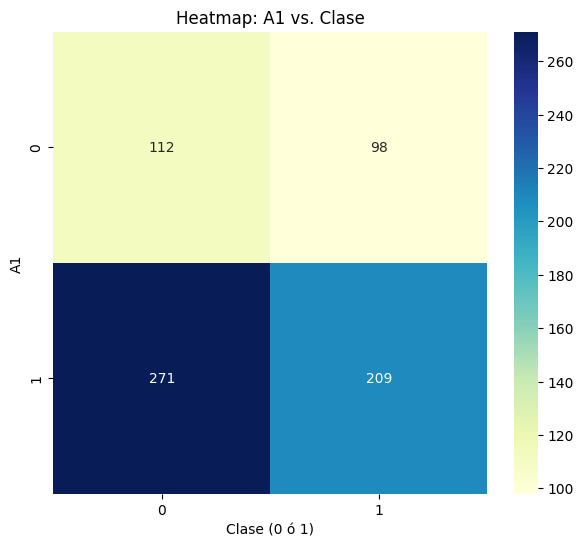

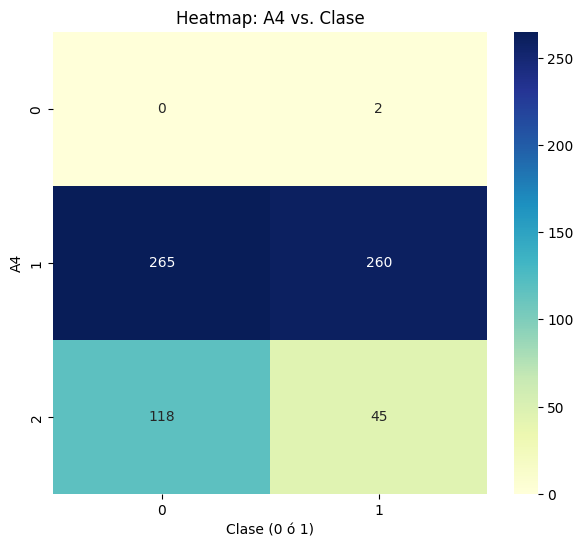

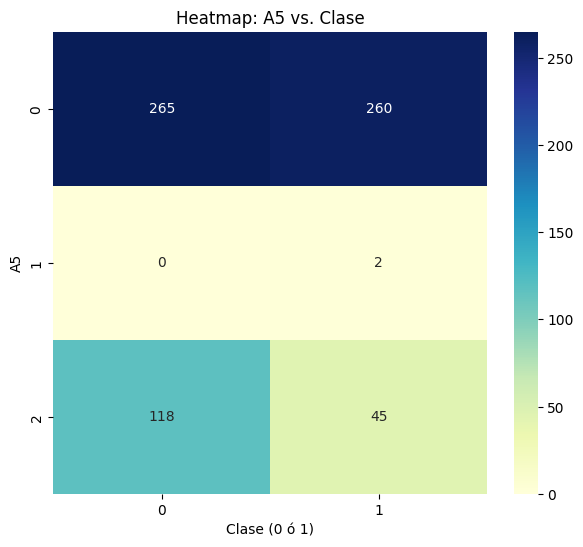

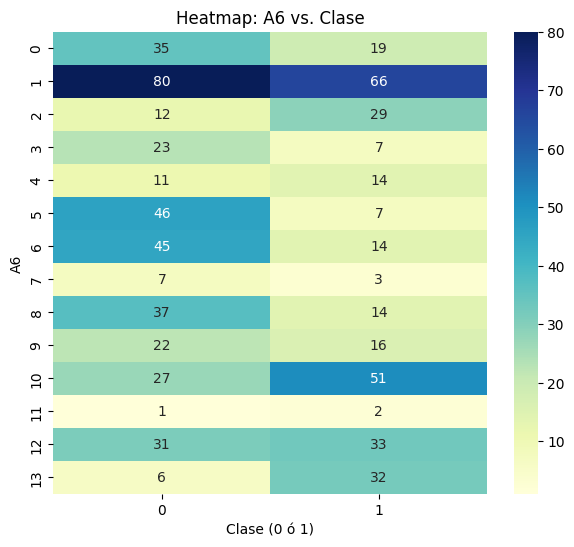

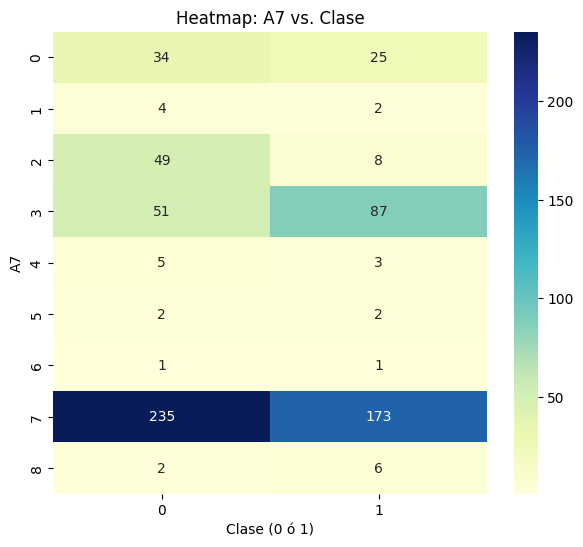

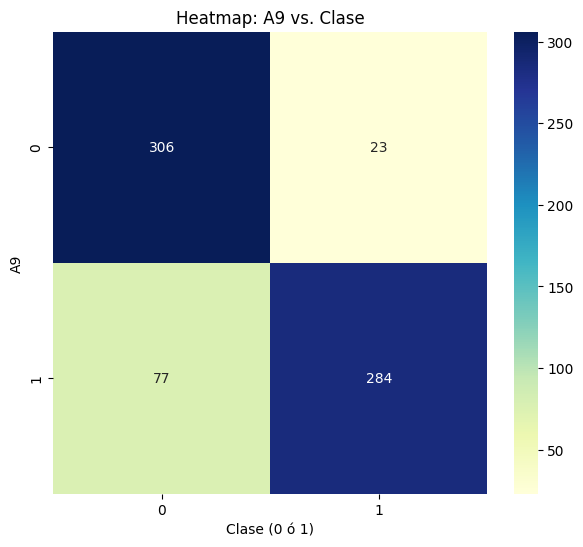

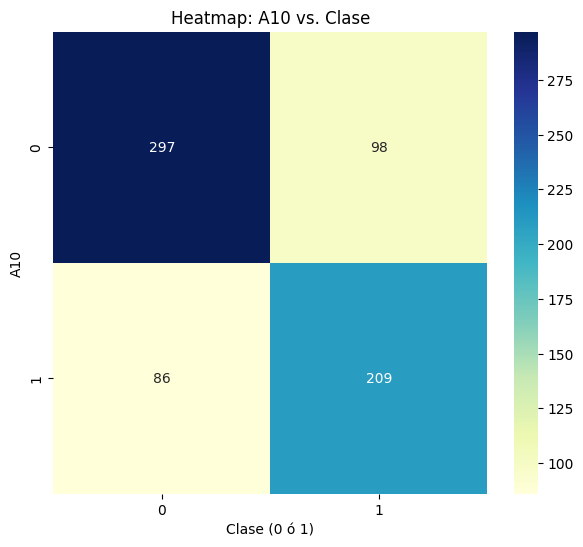

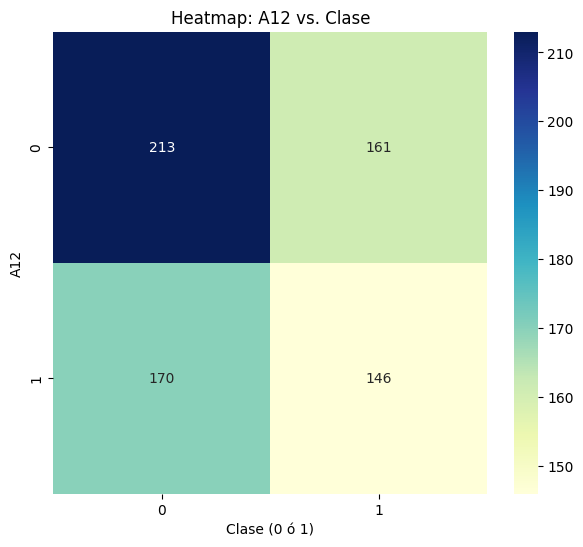

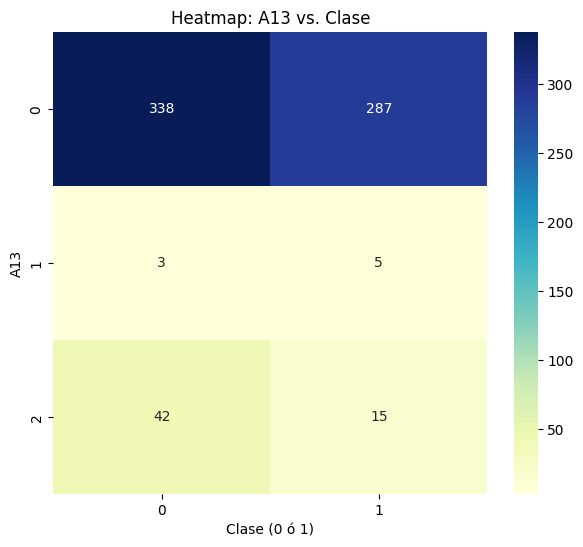

In [ ]:
for i in columnas_categoricas[:-1]:
# 1. Crea la tabla de contingencia (frecuencias)
    tabla_contingencia = pd.crosstab(df[i], df['clas.'])

    # 2. Visualiza como Heatmap
    sns.heatmap(tabla_contingencia, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f'Heatmap: {i} vs. Clase')
    plt.ylabel(f'{i}')
    plt.xlabel('Clase (0 ó 1)')
    plt.show()

Vemos que en las variables A10 y A9 hay una gran diferencia entre los valores clasificados como 1 y como 0, esto nos puede servir para clasificar ejemplos.

### Coeficientes de correlación de Pearson

Ahora hacemos el heatmap de los coeficientes de Correlación de Pearson entre las variables continuas

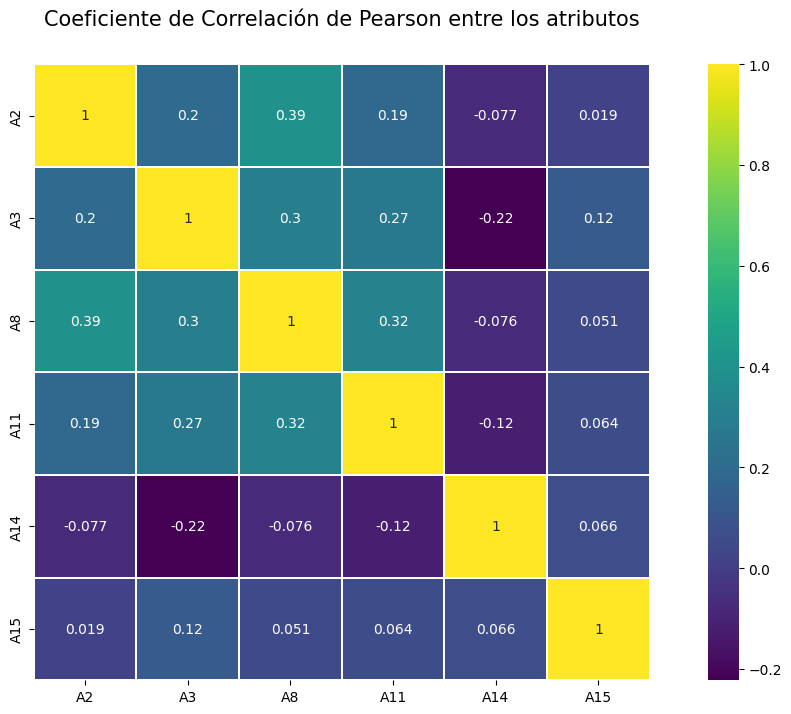

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Coeficiente de Correlación de Pearson entre los atributos', y=1.05, size=15)
sns.heatmap(df[columnas_continuas].corr(),linewidths=0.1,vmax=1.0,
            square=True, cmap='viridis', linecolor='white', annot=True)
plt.show()

Vemos que ningun par de variables está estrechamente correalacionada, ya sea de forma positiva o negativa. El par con mayor correlación son las variables A8 y A2 pero es de 0.39.

Por ejemplo, parece que A11 está relacionada con A2 con A3 y A8.

Por otro lado, vemos que la variable A15 tiene una correlación casi nula con el resto de variables, parece que que esta variable parece totalmente independiente de las otras.

## Modelado usando árbol de decisión. Conjunto test y de entrenamiento



Lo primero que haremos será separar nuestros datos en conjunto de entrenamiento y de test. Fijaremos un tamaño para el test de un 25% de la muestra total

In [ ]:
X = df.iloc[:, :-1]
y = df['clas.']

print(X.shape)

print(y.shape)
X


(690, 15)
(690,)


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,1,30.83,0.000,1,0,12,7,1.25,1,1,1,0,0,202.0,0
1,0,58.67,4.460,1,0,10,3,3.04,1,1,6,0,0,43.0,560
2,0,24.50,0.500,1,0,10,3,1.50,1,0,0,0,0,280.0,824
3,1,27.83,1.540,1,0,12,7,3.75,1,1,5,1,0,100.0,3
4,1,20.17,5.625,1,0,12,7,1.71,1,0,0,0,2,120.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,21.08,10.085,2,2,4,3,1.25,0,0,0,0,0,260.0,0
686,0,22.67,0.750,1,0,1,7,2.00,0,1,2,1,0,200.0,394
687,0,25.25,13.500,2,2,5,2,2.00,0,1,1,1,0,200.0,1
688,1,17.92,0.205,1,0,0,7,0.04,0,0,0,0,0,280.0,750


In [ ]:
X_train, X_test, y_train, y_test = \
  train_test_split(X,y,test_size = 0.25,random_state=462)

len(y_test)

173

Ahora pasamos a crear nuestro árbol y a representarlo

In [ ]:
tree3_clf = DecisionTreeClassifier(random_state=257)

tree3_clf.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,257
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


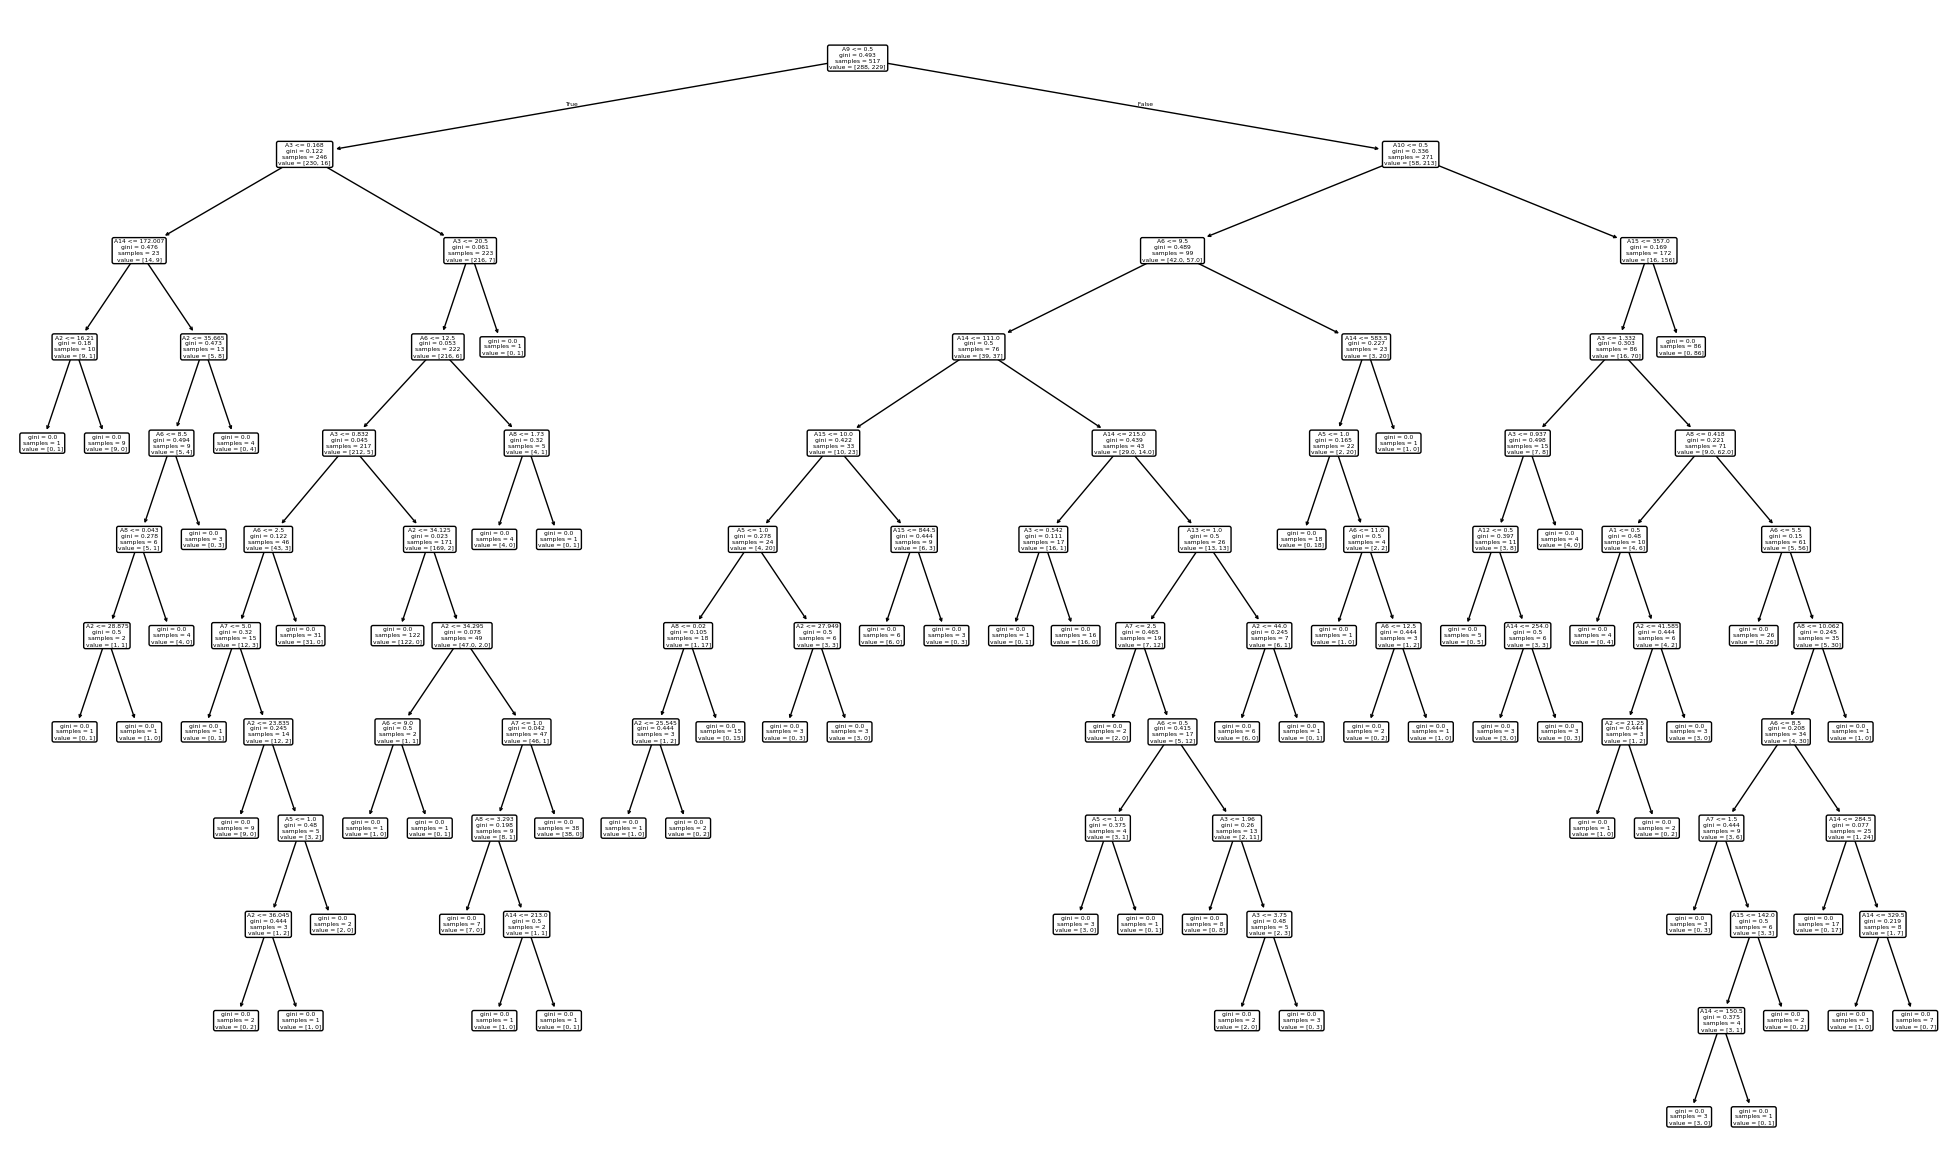

In [ ]:
plt.rcParams["figure.figsize"] = [25,15]
plot_tree(tree3_clf,rounded=True,feature_names=X.columns)
plt.show()

Con el árbol ya representado, el cuál es bastante complejo, vemos su *score*

In [ ]:
print("Rendimiento en el conjunto de entrenamiento: ",tree3_clf.score(X_train,y_train))
print("Rendimiento en el conjunto de prueba: ",tree3_clf.score(X_test,y_test))
print("Rendimiento en el conjunto total: ",tree3_clf.score(X,y))

Rendimiento en el conjunto de entrenamiento:  1.0
Rendimiento en el conjunto de prueba:  0.8497109826589595
Rendimiento en el conjunto total:  0.9623188405797102


Vemos que en el conjunto de entrenamiento nuestro árbol funciona perfectamente pues su rendimiento es de un 100%, en cambio con el conjunto de prueba es casi de un 85%, que es bastante alto. El rendimiento del conjunto total es de 96%. Igualmente el rendimiento que más nos interesa es en el conjunto de prueba, pues son los datos que nuestro modelo nunca ha visto, que acierte con los datos de entrenamiento es normal.

### Importancia de las variables

Una vez teniendo nuestro árbol, podemos medir la importancia de las variables. Esto nos puede ayudar a lo que posteriormente denominaremos como poda del árbol (reducir la complejidad del mismo). Esto es un atributo del propio árbol, basta con llamar a `feature_impotances_` de nuestro árbol

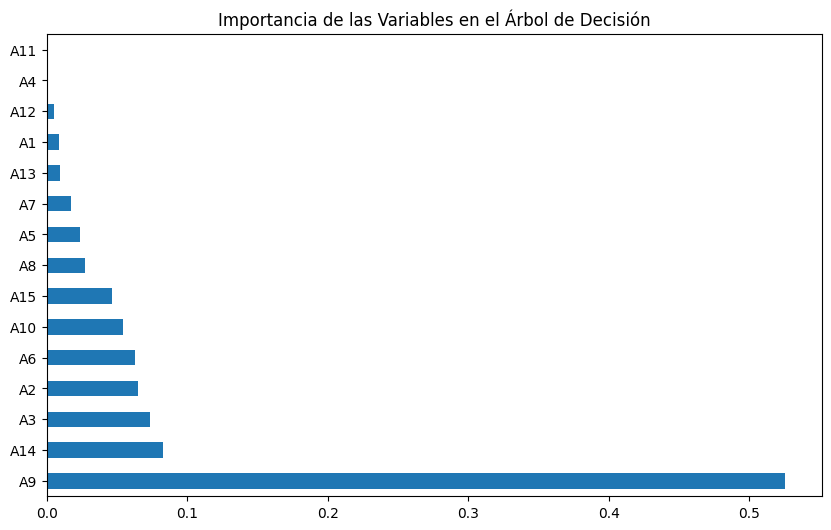

In [ ]:
# Accediendo al atributo del modelo ya entrenado
importancias = tree3_clf.feature_importances_

# Mapear las importancias con los nombres de las columnas
importancia_df = pd.Series(importancias, index=X_train.columns)

# Visualizar las más importantes
importancia_df.sort_values(ascending=False).plot(kind='barh', figsize=(10, 6))
plt.title('Importancia de las Variables en el Árbol de Decisión')
plt.show()

Vemos que la variable más importante y por mucha diferencia es A9, que tiene sentido con lo que vimos en las tablas de contingencia. Seguidas de A14 y de A3 que son ambas variables continuas. En las tablas de contingencia vimos que A10 también parecía útil para clasificar, pero en este caso no está de las más importantes, igual es porque tiene mucha correlación con A9 y teniendo la información aportada por A9, A10 no nos aporta mucha información nueva. Lo vemos a continuación. Pintamos una tabla de contingencia para ver la relacion entre estas dos variables y realizamos un *chi-square test* que está localizado en la librería `scipy`, él módulo `stats` y concretamente la función [`chi2_contingency`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html#scipy.stats.chi2_contingency)

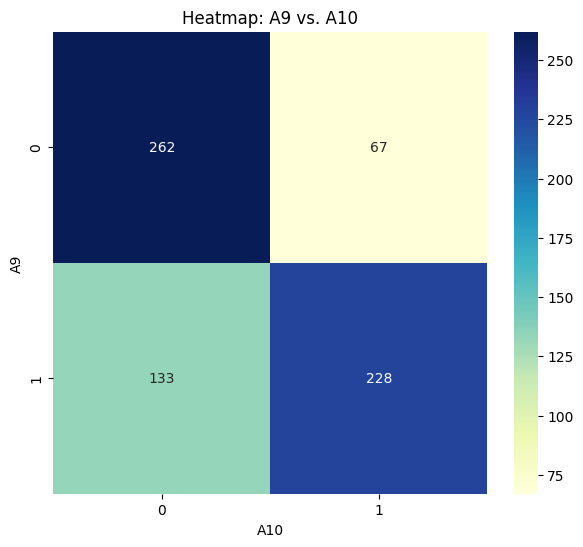


--- Resultados del Test Chi-Cuadrado ---
Valor Chi-Cuadrado (χ²): 127.047
Valor p (p-value): 0.0000
Grados de Libertad (df): 1

Frecuencias Esperadas (Si las variables son independientes): 
 A10      0      1
A9               
0    188.3  140.7
1    206.7  154.3


In [ ]:
tabla_contingencia = pd.crosstab(df['A9'], df['A10'])

# 2. Visualiza como Heatmap
plt.rcParams["figure.figsize"] = [7,6]
sns.heatmap(tabla_contingencia, annot=True, fmt='d', cmap='YlGnBu')
plt.title(f'Heatmap: A9 vs. A10')
plt.ylabel(f'A9')
plt.xlabel('A10')
plt.show()



# Realizar el test de Chi-Cuadrado
chi2, p_valor, grados_libertad, frecuencias_esperadas = chi2_contingency(tabla_contingencia)

print("\n--- Resultados del Test Chi-Cuadrado ---")
print(f"Valor Chi-Cuadrado (χ²): {chi2:.3f}")
print(f"Valor p (p-value): {p_valor:.4f}")
print(f"Grados de Libertad (df): {grados_libertad}")

# Opcional: Mostrar la tabla de frecuencias que se esperarían si NO hubiera relación
print("\nFrecuencias Esperadas (Si las variables son independientes):","\n",
      pd.DataFrame(frecuencias_esperadas, index=tabla_contingencia.index, columns=tabla_contingencia.columns).round(1))



Hemos también realizado un *chi-square test*, que usa una variable aleatoria de tipo $\chi^2$ para llevarse a cabo. El objetivo de este test es de comprobar si dada una tabla de contingencia las variables son independientes o no.

El test siempre se plantea con dos hipótesis opuestas:
 - Hipótesis Nula ($H_0$): Las dos variables categóricas son independientes. No existe una asociación significativa entre ellas (ej., la clase de una persona no depende de su género).
  - Hipótesis Alternativa ($H_A$): Las dos variables categóricas son dependientes o están asociadas significativamente (ej., la clase de una persona sí depende de su género).

El estadístico $\chi^2$ cuantifica la diferencia entre las frecuencias observadas y las frecuencias esperadas si realmente las variables fueran independientes.

 - Fórmula: Se calcula sumando las diferencias al cuadrado entre lo observado y lo esperado, dividido por lo esperado, para todas las celdas de la tabla.$$  \chi^2 = \sum \frac{(O - E)^2}{E} $$

Interpretación del Valor $\chi^2$:
 - $\chi^2$ pequeño (cercano a 0): Significa que $O \approx E$. Las frecuencias observadas son muy similares a lo que se esperaría por azar. Apoya $H_0$.
 - $\chi^2$ grande: Significa que $O$ y $E$ son muy diferentes. Las diferencias no son atribuibles al azar. Apoya $H_A$.

El valor $\chi^2$ se utiliza para calcular el $p$-valor (p-value), que es la probabilidad de observar un valor tan extremo (o más extremo) si la hipótesis nula fuera cierta.
- Regla General: Se compara el $p$-valor con un Nivel de Significación ($\alpha$), que típicamente es 0.05. Es decir, lo usaremos como una medida de evidencia para ver si podemos rechazar la hipotesis nula $H_0$ o no tenemos evidencias suficientes para rechazarla.

Conclusión del test:
 - Si $p \leq 0.05$: Rechazamos $H_0$. Concluimos que hay suficiente evidencia estadística para afirmar que existe una asociación significativa entre las variables.
 - Si $p > 0.05$: No rechazamos $H_0$. Concluimos que no hay suficiente evidencia para afirmar que las variables están asociadas.


Como el $p$-valor de nuestro test es $0 < 0.05$ rechazamos la hipotesis nula, es decir, las variables no son independientes. O dicho de otra forma, las variables están relacionada entre sí. Esto podría explicar por qué se ha elegido A9 como variable importante y A10 no cuando en las tablas de contingencia veíamos que ambas podían servir  claramente para la clasificación. Pero claro como A9 y A10 están relacionadas, quizás teniendo la información de A9, la variable de A10 no aporta mucha "información nueva".

### Validación cruzada

Lo que vamos a hacer en este apartado es validación cruzada, que consiste en obtener una estimación más fiable del rendimiento del modelo al dividir el conjunto de entrenamiento en $k$ partes (*folds*), entrenar el modelo $k$ veces y hacer la media de los resultados.

In [ ]:
cross_validation = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 462)
scores = cross_val_score(tree3_clf, X, y,
                                 scoring = "accuracy", cv = cross_validation, n_jobs = 1 )
scores

array([0.76811594, 0.76811594, 0.7826087 , 0.89855072, 0.76811594,
       0.82608696, 0.86956522, 0.84057971, 0.84057971, 0.82608696])

In [ ]:
print(f"Puntuaciones de Validación Cruzada (k=10): {scores}")
print(f"Exactitud Promedio: {scores.mean():.4f}")
print(f"Desviación Estándar de Exactitud: {scores.std():.4f}")

Puntuaciones de Validación Cruzada (k=10): [0.76811594 0.76811594 0.7826087  0.89855072 0.76811594 0.82608696
 0.86956522 0.84057971 0.84057971 0.82608696]
Exactitud Promedio: 0.8188
Desviación Estándar de Exactitud: 0.0436


Vemos que la exactitud promedio es del 81.9% y la desviación de estandar es del 0.04. Vemos que es una desviación estándar pequeña y la exactitud es elevada, por lo que nuestro modelo es robusto

### Poda. Optimización de hiperparámetros.

Ahora vamos a buscar los mejores valores para varios parámetros a la vez con SearchGrid igual que se hizo en la práctica.

In [ ]:
parameters = {
    'criterion':['gini', 'entropy'],
    'max_depth':[None,3,4,7,10],
    'max_features':['sqrt', 'log2'],
    'max_leaf_nodes':[None, 10,25, 50],
    'min_impurity_decrease':[0.0, 0.001, 0.01],
    'min_samples_leaf':[8, 10, 12, 14,20],
    'min_samples_split': [2,3,8,9]
}

clf = GridSearchCV(DecisionTreeClassifier(random_state=10), parameters, cv=10, scoring='accuracy')

clf.fit(X_train, y_train)
print('Mejores hiperparámetros encontrados:', clf.best_params_)

Mejores hiperparámetros encontrados: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 8, 'min_samples_split': 2}


Creamos ahora un árbol, que será nuestro árbol óptimo con los parametros calculados. Esto es una forma de podar el árbol. Recordemos que podar un árbol consiste en reducir su complejidad haciendolo más "pequeño", cosa que nos ayuda también a evitar el sobreajuste. Tenemos varias formas de podar un árbol, algunas son:
 - *Max_depth*: Limitamos la profundidad máxima del árbol
 - *Min_samples_leaf*: limitamos el número mínimo de ejemplos requeridos en un nodo hoja.
 - *Min_impurity_decrease*: Especifica el valor mínimo que debe disminuir la impureza (Gini o Entropía) para que se realice una división.

Nuestro calculos en este caso, vamos a fijar el parámetro *max_depth* con un valor de 4, el *min_samples_leaf* con un valor de 6 y el *min_impurity_decrease* con un valor de 0.01

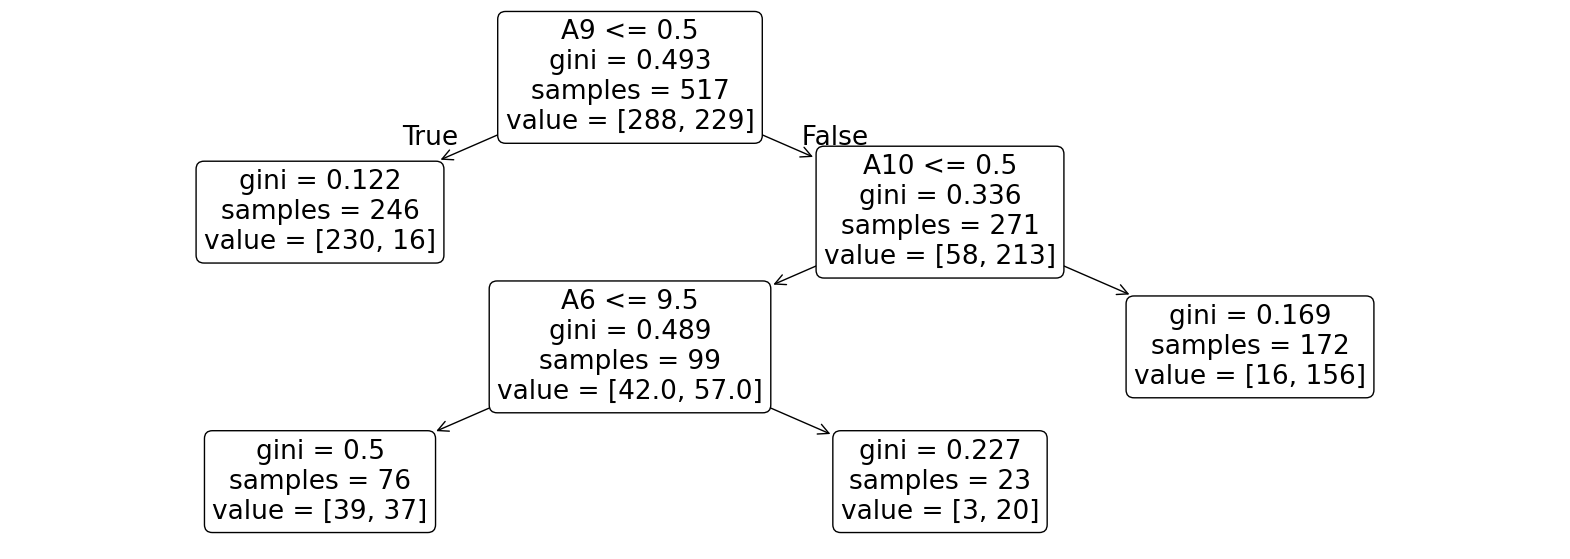

In [ ]:
plt.rcParams["figure.figsize"] = [20,7]
final_tree = DecisionTreeClassifier(random_state=208,max_features='sqrt',min_samples_leaf=8,min_impurity_decrease=0.01
        ,max_depth=4)
final_tree.fit(X_train,y_train)
plot_tree(final_tree,rounded=True,feature_names=X.columns)
plt.show()


In [ ]:
print("Rendimiento en el conjunto de entrenamiento: ",final_tree.score(X_train,y_train))
print("Rendimiento en el conjunto de prueba: ",final_tree.score(X_test,y_test))
print("Rendimiento en el conjunto total: ",final_tree.score(X,y))

Rendimiento en el conjunto de entrenamiento:  0.8607350096711799
Rendimiento en el conjunto de prueba:  0.8554913294797688
Rendimiento en el conjunto total:  0.8594202898550725


Acabamos de calcular el rendimiento del árbol final, que vemos que aunque no tiene rendimiento 1 en el conjunto de entrenamiento tiene un buen rendimiento (85.55%) en el conjunto que prueba. De hecho más que en el último árbol que teníamos. Recordamos que el rendimiento en el conjunto de prueba es el que más interesa pues son los ejemplos que nuestro modelo no había visto antes.

Y evidentemente este árbol es mucho más simple que el que teníamos antes por lo que ha aumentado muchisimo su explicabilidad. Vemos que solo hacemos a lo sumo 3 preguntas. Preguntamos por A9, por A10 y por A6. Como no podía ser de otro modo, la variable A9, nos ayuda un montón con la clasificación pues si la respuesta a la pregunta es True ya hacemos una clasificación directamente. Cosa que cuadra perfectamente con la tabla de contingencia que vimos al principio y con la alta importancia de la variable A9 cuando vimos la importancia de las variables.

Vemos que A10 y A6 no eran las variables más importantes en el gráfico de importancia de variables pero aquí preguntamos por ella. Esto puede deberse sin ir más lejos, a la propia aleatoreidad de las semillas, pues recordamos que A10 y A6 tenían importancias casi similares a A2, A3 y A14.

### Matriz de confusión. Curva ROC-AUC

Vamos a ver ahora la matriz de confusión

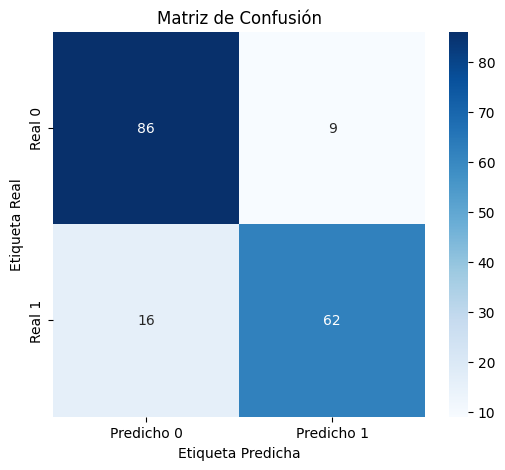

In [ ]:
# Matriz de confusión
cm = skm.confusion_matrix(y_test, final_tree.predict(X_test))

# Visualizar como Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicho 0', 'Predicho 1'],
    yticklabels=['Real 0', 'Real 1']
)
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

Tendríamos que preguntar cómo de costoso es que se clasifique a alguien como negativo que sea positivo. Pues no es lo mismo dar un falso negativo ante una enfermedad por ejemplo, que es algo muy costoso y es mejor dar falsos positivos a dar falsos negativos que por ejemplo clasificar un tipo de flor como en el conjunto de datos iris visto en la práctica. O de forma contraria, igual el coste de un falso positivo es elevado, por ejemplo realizar un costoso tratamiento a alguien que no lo necesita. Esto viene ligado con los valores de sensibilidad y de especifidad, que veremos a continuación.

La matriz de confusión la podemos ver de la siguiente forma

| | **Predicho Negativo (0)** | **Predicho Positivo (1)** |
| :--- | :---: | :---: |
| **Real Negativo (0)** | VN (Verdaderos Negativos) | FP (Falsos Positivos) |
| **Real Positivo (1)** | FN (Falsos Negativos) | VP (Verdaderos Positivos) |


A partir de esta tabla podemos definir varios parámetros:

 - Rendimiento (Accuracy): proporción de ejemplos bien clasificados (es lo que calculamos con *score*)
$$\text{Rendimiento} = \frac{\text{VP} + \text{VN}}{\text{VP} + \text{VN} + \text{FP} + \text{FN}}$$

 - Sensibilidad (Sensitivity): es la proporción de casos positivos reales que fueron correctamente identificados por el modelo. Es decir, de todos los ejemplos  que eran positivos, ¿cuántos se clasificaron correctamente como positivos?
 $$\text{Sensibilidad} = \frac{\text{VP}}{\text{VP} + \text{FN}}$$

 - Especificidad (Specificity): es la proporción de casos negativos reales que fueron correctamente identificados por el modelo. Es decir, de todos los ejemplos que eran negativos. ¿cuántos se clasificaron correctamente como negativos?
 $$\text{Especificidad} = \frac{\text{VN}}{\text{VN} + \text{FP}}$$

Calculamos estos parámetros en nuestro modelo

In [ ]:
print(f"RENDIMIENTO : {(cm[1,1]+ cm[0,0])/ sum(sum(cm))}")
print("\n")
print(f"SENSIBILIDAD : {cm[1,1]/(cm[1,1]+cm[1,0])}")
print("\n")
print(f"ESPECIFIDAD : {cm[0,0]/(cm[0,0]+cm[0,1])}")

RENDIMIENTO : 0.8554913294797688


SENSIBILIDAD : 0.7948717948717948


ESPECIFIDAD : 0.9052631578947369


Ya depende de los tipos de datos y el test si queremos un modelo más específico o más sensible (lo ideal es muy sensible y muy específico, pero esto en la vida real no suele salir). Igual se quiere un modelo que no deje ni un solo positivo sin detectar aunque se clasifiquen algunos negativos como positivos (por ejemplo si queremos detectar algún tipo de enfermedad), o viceversa, igual queremos no queremos fallar la clasificación de negativos aunque algún positivo lo clasifiquemos como negativo (por ejemplo, si usamos un modelo para detectar ladrones y mandarlos a la cárcel, igual preferimos dejar algún ladrón suelto antes que mandar a la cárcel a gente inocente).

Aquí es donde introducimos el concepto de **umbral**. Internamente para hacer una predicción de clasificación binaria, el modelo asigna al dato dado una probabilidad de pertenecer al grupo positivo. De forma natural, se clasifica el dato como el grupo al que más probabilidad tenga de pertenecer. En este caso el umbral es de 0.5, es decir que si esta probabilidad es mayor que 0.5 lo asignaremos a la clase positiva, si no a la clase negativa. Pero, podemos mover este umbral si quisieramos que no se nos pase ningun ejemplo positivo o negativo (mejorar la sensibilidad o la especificidad respectivamente). Por defecto este umbral es de 0.5, concretando en los árboles que es lo que estamos viendo, se ve pues dado un nodo final asignamos como resultado el grupo del que más ejemplos haya, pero se podría mover este umbral también para requerir un 60% de ejemplos positivos en el nodo para clasificarlo como positivo por ejemplo haciendo así una clasificación mejor para negativos, o un 30% para que clasifiquemos correctamente más positivos.

Con esto claro podemos definir la curva ROC y su área bajo la curva (AUC). Podemos recorrer todos los valores posibles de umbral (entre 0 y 1) y calcular la especifididad y la sensibilidad que resultan y pintar una curva de la siguiente forma:

 - Eje Y : Sensibilidad
 - Eje X : 1 - Especifidad

Esta es la **Curva ROC**, que es una forma de visualizar la bondad de ajuste de nuestro modelo. Como queremos que idealmente nuestro modelo tenga tanto especificidad 1 como sensibilidad 1, cuánto más se acerque la curva al punto (0,1), mejor será nuestro modelo.

La curva ROC, viene de la mano con el área bajo la curva (**AUC**), pues como queremos que idealmente la curva llegue hasta el (0,1), queremos que el área bajo la curva sea lo más cercano a 1 posible. El AUC es otra medida de bondad de ajuste.

De forma regular se suele representar la curva ROC con una línea diagonal a 45 grados (desde (0,0) hasta (1,1)) que un modelo que clasifica al azar. Su rendimiento es igual al 0.5 AUC. Cuanto mas se alce nuestra curva ROC respecto de esa línea, mejor.

Representamos ahora la curva ROC para nuestro árbol optimizado, que se encuentra en la libreria `scikit-learn`, en el módulo `metrics`, concretamente la función [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) sirve para obtener el AUC, mientras que la  función [`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) calcula la curva ROC. Resaltamos el punto que corresponde a nuestra especifidad y a nuestra sensibilidad, con umbral 0.5


Puntuación AUC-ROC en Test: 0.9016


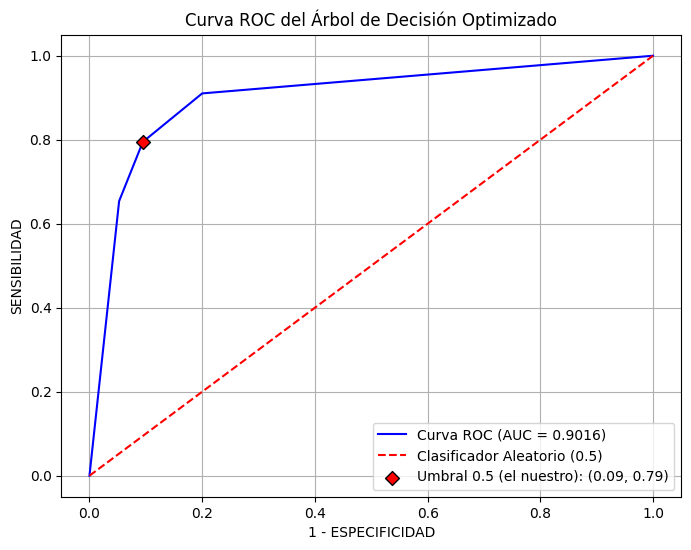

In [ ]:
y_pred_proba = final_tree.predict_proba(X_test)[:, 1]

# Calculo de la puntuación AUC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\nPuntuación AUC-ROC en Test: {auc_roc:.4f}")

# Calculo de la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Grafica la Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Clasificador Aleatorio (0.5)') # Línea de base
plt.xlabel('1 - ESPECIFICIDAD')
plt.ylabel('SENSIBILIDAD')
plt.title('Curva ROC del Árbol de Decisión Optimizado')
plt.scatter(1-cm[0,0]/(cm[0,0]+cm[0,1]), cm[1,1]/(cm[1,1]+cm[1,0]),
            color='red',
            s=50,
            marker='D',        # Usar un marcador diferente (Diamante)
            edgecolor='black', # Añadir un borde negro
            zorder=5,          # Asegurar que esté delante de todo
            label=f'Umbral 0.5 (el nuestro): ({1-cm[0,0]/(cm[0,0]+cm[0,1]):.2f}, {cm[1,1]/(cm[1,1]+cm[1,0]):.2f})')
plt.legend()
plt.grid(True)
plt.show()

Vemos que el AUC de nuestra curva ROC es de 0.90, bastante próximo a 1. Lo que indica que tenemos un buen modelo.